In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.models import *
plt.style.use('ggplot')

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import plot_roc_curve, confusion_matrix, classification_report

In [61]:
fake_df = pd.read_csv('data/Fake.csv')
true_df = pd.read_csv('data/True.csv')

In [62]:
fake_df.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [63]:
fake_df['truth'] = 0
true_df['truth'] = 1
true_df['text'] = true_df['text'].apply(remove_organization)
true_df['title'] = true_df['title'].str.replace('Factbox: ', '')
fake_df['title'] = fake_df['title'].str.replace(r"\(.*\)","")
fake_df['title'] = fake_df['title'].str.replace('WATCH:', '')
all_news_df = pd.concat([fake_df, true_df])

In [64]:
def get_X_y_splits(df, X_col, y_col='truth'):
    ''' Takes a dataframe and returns a train test split for labeled data.
    Input: DataFrame, X column name (string), target column name (string).
    Ouput: X_train, X_test, y_train, y_test'''
    X = df[X_col].values
    y = df[y_col].values
    return train_test_split(X, y)

In [65]:
X_train, X_test, y_train, y_test = get_X_y_splits(all_news_df, 'title')

In [85]:
baseline_clf = baseline_model(X_train, y_train)

/home/kellen/anaconda3/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


In [66]:
nb_clf = naive_bayes_model(X_train,y_train)

In [67]:
nb_predicted = nb_clf.predict(X_test)
nb_clf.score(X_test, y_test)

0.9367483296213809

In [68]:
sgd_clf = stochastic_gradient_descent_model(X_train,y_train)

In [69]:
sgd_predicted = sgd_clf.predict(X_test)
sgd_clf.score(X_test, y_test)

0.9396881959910913

In [70]:
pa_clf = passive_aggressive_model(X_train,y_train)

In [71]:

pa_clf_predicted = pa_clf.predict(X_test)
pa_clf.score(X_test, y_test)

0.9521603563474388

In [99]:
coefs = pa_clf.best_estimator_.named_steps.clf.coef_
bag = pa_clf.best_estimator_.named_steps.vect.get_feature_names()

In [100]:
freq_df = pd.DataFrame(index=bag, data={'coefs': coefs[0]})
freq_df = freq_df.iloc[(-freq_df['coefs'].abs()).argsort()]
freq_df.head()

,coefs
video,-12.076322
breaking,-8.125307
gop,-8.093154
hillary,-8.002629
just,-6.977272


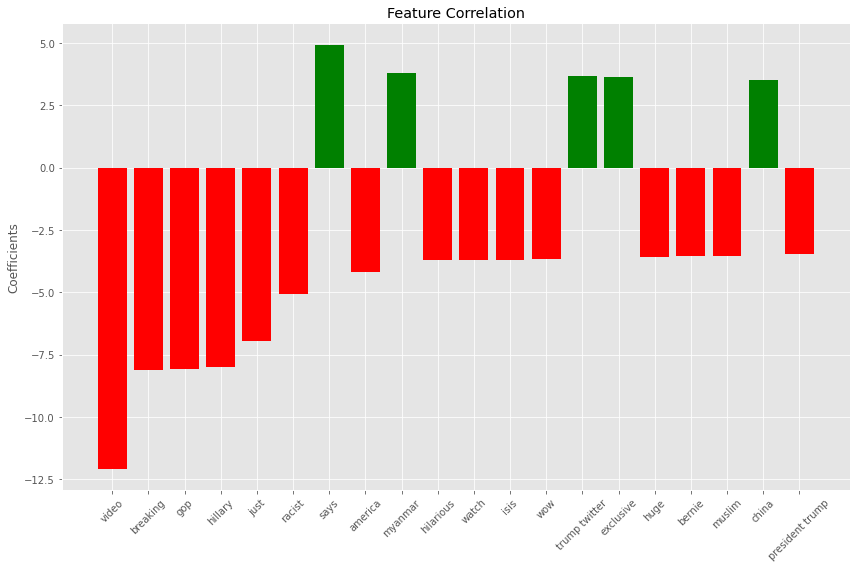

In [96]:
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(freq_df.index[:20], freq_df['coefs'][:20].values, color=(freq_df['coefs'][:20] > 0).map({True:'green',False:'red'}))
ax.tick_params(axis='x', labelrotation=45)
ax.set_title('Feature Correlation')
ax.set_ylabel('Coefficients')
# fig.savefig('images/feature_correlation')
fig.tight_layout()

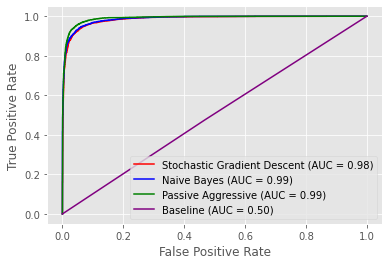

In [87]:
fig, ax = plt.subplots()
plot_roc_curve(sgd_clf, X_test, y_test, name='Stochastic Gradient Descent', ax=ax, color='red')
plot_roc_curve(nb_clf, X_test, y_test, name='Naive Bayes', ax=ax, color='blue')
plot_roc_curve(pa_clf, X_test, y_test, name='Passive Aggressive', ax=ax, color='green')
plot_roc_curve(baseline_clf, X_test, y_test, name='Baseline', ax=ax, color='purple')
# ax.set_ylim(.8,1.01)
# ax.set_xlim(0,.2)

In [77]:
confusion_matrix(y_test, nb_predicted)

array([[5731,  170],
       [ 540, 4784]])

In [76]:
confusion_matrix(y_test, sgd_predicted)

array([[5560,  341],
       [ 336, 4988]])

In [78]:
confusion_matrix(y_test, pa_clf_predicted)

array([[5678,  223],
       [ 314, 5010]])

In [79]:
print(classification_report(y_test, sgd_predicted, target_names=['Fake News','Real News']))

              precision    recall  f1-score   support

   Fake News       0.94      0.94      0.94      5901
   Real News       0.94      0.94      0.94      5324

    accuracy                           0.94     11225
   macro avg       0.94      0.94      0.94     11225
weighted avg       0.94      0.94      0.94     11225



In [98]:
test_title = ["Protesters ignite fury after shutting down packed Florida highway"]
pa_clf.predict(test_title)

array([1])